In [1]:
import pandas as pd
import numpy as np
import emoji
import nltk
import ssl

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Emoji-related functions

In [2]:
def emojiname2icon(name):
    return emoji.emojize(f":{name.replace(' ','_')}:")

emojiname2icon('smiling face with hearts')

'🥰'

## Function: Remove special characters 

In [3]:
import re

def remove_special(text):
    # Remove URLs
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = url_pattern.sub('', text)
    
    # Remove words starting with # and @ for all languages
    hashtag_pattern = re.compile(r'(?:^|\s)[@#](?:\w+|[^\s\w])+')
    text = hashtag_pattern.sub('', text)
    
    # Remove punctuation
    punctuation_pattern = re.compile(r'[^\w\s]', re.UNICODE)
    text = punctuation_pattern.sub('', text)
    

    # Remove emoji, number, tab
    emoji_number_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"0-9"           # numbers
        u"\n\t"           # newline and tab characters

                           "]+", flags=re.UNICODE)
    text = emoji_number_pattern.sub(r'', text)

    return text

remove_special('💋💫😀\nProduction appear product door 1234')

'Production appear product door '

## Function: Remove stop words and lemmatization

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
  
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def remove_stopword_and_lemmatized(text):
    #tokenized and change to lower
    word_tokens = word_tokenize(text.lower())

    #remove stop word
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    #get part of speech
    pos = nltk.pos_tag(filtered_sentence)

    #lemmatization with POS
    lemmeanized_sentence = [lemmatizer.lemmatize(filtered_sentence[i],get_wordnet_pos(pos[i][1])) if get_wordnet_pos(pos[i][1]) != None else lemmatizer.lemmatize(filtered_sentence[i]) for i in range(len(filtered_sentence))]

    #remove duplicates (in order)
    return " ".join(list(dict.fromkeys(lemmeanized_sentence)))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Function: Apply preprocessing functions

In [5]:
def content_preprocessing(df):
    df['cleaned content'] = df['content'].apply(remove_special)
    df['cleaned_content'] = df['cleaned content'].apply(remove_stopword_and_lemmatized)
    
    #get emoji id for name
    df['emoji_id'] = df['emoji_name'].apply(lambda name: emojiname2id_dic[name])
    
    return df[['emoji_id','content','cleaned_content']]

## Combine data from different data sources

In [6]:
#Produce Emoji_DF[emoji_id, emoji_name]
top_20_emoji_name = [

    'face with tears of joy', # funny happy
    
    'red heart', #love
    
    'broken heart', #no love
    
    'thumbs up', #encouragement
    
    'smiling face with smiling eyes', #happy
    
    'loudly crying face', #pure sad
    
    'clapping hands', #congradualation
    
    'fire', #hot /sexy
    
    'face screaming in fear', #shock
    
    'pile of poo', #non-sense, disapproval
    
    'face with symbols on mouth', #anger
    
    'eggplant', #horny
    
    'face savoring food', # craving
    
    'hundred points', #approval
    
    'folded hands', #pray
    
]

emoji_reference = {'emoji_name':top_20_emoji_name,'emoji_id':[i for i in range(len(top_20_emoji_name))]}
emoji_df =  pd.DataFrame(emoji_reference)
emoji_df

emojiname2id_dic = {emoji_df.emoji_name[i]:emoji_df.index[i] for i in range(len(emoji_df.index))}
emojiid2name_dic = {emoji_df.index[i]:emoji_df.emoji_name[i] for i in range(len(emoji_df.index))}

# load data from different data source
scrape1 = pd.read_csv('processed_data.csv', index_col = 0)
scrape2 = pd.read_csv('processed_data_batch2.csv')

df = pd.DataFrame(columns=['emoji_name','emoji','content','cleaned content'])
df = pd.concat([df,scrape1,scrape2])
top_20_emoji_df = pd.DataFrame(columns=['emoji_name','emoji','content','cleaned content'])
for name in top_20_emoji_name:
    top_20_emoji_df = pd.concat([top_20_emoji_df,df[df.emoji_name==name]])

kaggle_tweets = pd.read_csv('kaggle_tweets 15 selected emoji.csv',names=['emoji_name','content'])


In [7]:
# Concat everything togehter 
total_df = pd.concat([top_20_emoji_df,kaggle_tweets])
total_df

,emoji_name,emoji,content,cleaned content
47,face with tears of joy,😂,@PeakSanti But why this photo?😀😀😂😂,But why this photo?😀😀😂😂
206,face with tears of joy,😂,@Sachin_Ro45 Mass troll 😀😀😀😀😂😂😂😂😂😂\n@AdnanSami...,Mass troll 😀😀😀😀😂😂😂😂😂😂\n plz watch this video
386,face with tears of joy,😂,The people I work with thinks the bank has all...,The people I work with thinks the bank has all...
426,face with tears of joy,😂,@Jamespa97888596 😂😂😂 all friends again 👌👌😀,😂😂😂 all friends again 👌👌😀
454,face with tears of joy,😂,How you so in love with a nigga that's never w...,How you so in love with a nigga that's never w...
...,...,...,...,...
7390713,loudly crying face,NaN,&amp; to think I was going to split my tax ref...,NaN
7390714,face with tears of joy,NaN,&amp; to think I was going to split my tax ref...,NaN
7390715,loudly crying face,NaN,please !! remove the suspension from the pleas...,NaN
7390716,clapping hands,NaN,please. 👏🏼 so because i stan someone means i d...,NaN


## Sampled training and testing data from combined data

In [8]:
def get_n_sample(df, n, random_state):
    sample_data =  pd.DataFrame()
    for name in top_20_emoji_name:
        sample = df[df.emoji_name == name].sample(n=n,  random_state=random_state)
        sample_data = pd.concat([sample_data,sample])
    return sample_data

In [9]:
# randomly sampled from total df for tarining and testing 
from sklearn.model_selection import train_test_split

# Change sample size to 10000 from 8000; test_size changed to 0.2 from 0,4
train, test = train_test_split(get_n_sample(total_df,15000,4222), test_size=0.3,random_state=4222)

# apply data preprocessing on selected content
train_df, test_df = content_preprocessing(train), content_preprocessing(test)

In [10]:
# remove trained data with cleaned content > 0 words
train_df['cleaned_content_len']= train_df.cleaned_content.apply(lambda x: len(x.split()))
test_df['cleaned_content_len']= test_df.cleaned_content.apply(lambda x: len(x.split()))
train_df, test_df  = train_df[train_df.cleaned_content_len >=1],test_df[test_df.cleaned_content_len >=1]

C:\Users\user\AppData\Local\Temp\ipykernel_11456\3036399428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cleaned_content_len']= train_df.cleaned_content.apply(lambda x: len(x.split()))
C:\Users\user\AppData\Local\Temp\ipykernel_11456\3036399428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cleaned_content_len']= test_df.cleaned_content.apply(lambda x: len(x.split()))


# LSTM

In [11]:
# !pip install --upgrade pip
# !pip install tensorflow

import random
import tensorflow as tf
import tensorflow.keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
random.seed(4222)
emoji_shuffled = shuffle(emoji_df)
print(emoji_shuffled)

                        emoji_name  emoji_id
5               loudly crying face         5
9                      pile of poo         9
12              face savoring food        12
1                        red heart         1
11                        eggplant        11
3                        thumbs up         3
6                   clapping hands         6
10      face with symbols on mouth        10
13                  hundred points        13
2                     broken heart         2
14                    folded hands        14
0           face with tears of joy         0
8           face screaming in fear         8
4   smiling face with smiling eyes         4
7                             fire         7


In [13]:
split_index = len(train_df)
total_emoji_number = len(emoji_df)

In [14]:
file = open('glove.6B.100d.txt', 'r', encoding = 'utf8')
content = file.readlines()
file.close()

embeddings = {}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype = float)

In [15]:
# COMBINING 

df = pd.concat([train_df, test_df])

X = df["cleaned_content"].values
y = pd.get_dummies(df["emoji_id"].values)

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=" ", lower=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, truncating = "pre", padding = "pre", maxlen = 40)

X_train = X_pad[:split_index]
y_train = y[:split_index]
X_test = X_pad[split_index:]
y_test = y[split_index:]

In [16]:
word2index = tokenizer.word_index
word2index

{'get': 1,
 'like': 2,
 'im': 3,
 'love': 4,
 'amp': 5,
 'go': 6,
 'good': 7,
 'u': 8,
 'day': 9,
 'dont': 10,
 'make': 11,
 'follow': 12,
 'one': 13,
 'see': 14,
 'thank': 15,
 'retweet': 16,
 'back': 17,
 'time': 18,
 'new': 19,
 'happy': 20,
 'want': 21,
 'know': 22,
 'rt': 23,
 'look': 24,
 'need': 25,
 'say': 26,
 'come': 27,
 'please': 28,
 'let': 29,
 'cant': 30,
 'today': 31,
 'take': 32,
 'best': 33,
 'much': 34,
 'well': 35,
 'fuck': 36,
 'year': 37,
 'shit': 38,
 'everyone': 39,
 'video': 40,
 'people': 41,
 'think': 42,
 'really': 43,
 'man': 44,
 'god': 45,
 'watch': 46,
 'great': 47,
 'na': 48,
 'tweet': 49,
 'never': 50,
 'guy': 51,
 'give': 52,
 'still': 53,
 'life': 54,
 'keep': 55,
 'yall': 56,
 'girl': 57,
 'right': 58,
 'big': 59,
 'work': 60,
 'always': 61,
 'miss': 62,
 'thanks': 63,
 'thing': 64,
 'thats': 65,
 'feel': 66,
 'even': 67,
 'youre': 68,
 'friend': 69,
 'help': 70,
 'last': 71,
 'ever': 72,
 'wait': 73,
 'luck': 74,
 'first': 75,
 'http': 76,
 'heart'

In [17]:
embed_size = 100
embedding_matrix = np.zeros((len(word2index)+1, embed_size))

for word, i in word2index.items():
    embed_vector = embeddings.get(word)
    if embed_vector is not None:
        embedding_matrix[i] = embed_vector

In [18]:
vocabulary_size = len(tokenizer.word_index)
seq_len = 40
embed_len = 100 ### originally 20

model = Sequential()
model.add(Embedding(vocabulary_size+1, embed_len, input_length = seq_len, weights = [embedding_matrix]))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(40))
model.add(Dropout(0.8))
model.add(Dense(15, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           7263700   
                                                                 
 lstm (LSTM)                 (None, 40, 80)            57920     
                                                                 
 dropout (Dropout)           (None, 40, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 15)                615       
                                                                 
Total params: 7,341,595
Trainable params: 7,341,595
Non-

In [19]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=1, verbose=1)

model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [20]:
tf.config.run_functions_eagerly(True)

batch_size = 128
epochs = 10

model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size, 
    epochs = epochs, 
    shuffle = True,
    validation_data = (X_test, y_test),
    callbacks = [early_stop]
)

Epoch 1/10


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1225/1225 [==============================] - ETA: 0s - loss: 2.5360 - accuracy: 0.1642

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1225/1225 [==============================] - 681s 556ms/step - loss: 2.5360 - accuracy: 0.1642 - val_loss: 2.2796 - val_accuracy: 0.2804
Epoch 2/10
1225/1225 [==============================] - 676s 552ms/step - loss: 2.3206 - accuracy: 0.2555 - val_loss: 2.1614 - val_accuracy: 0.3217
Epoch 3/10
1225/1225 [==============================] - 683s 557ms/step - loss: 2.1871 - accuracy: 0.3068 - val_loss: 2.1129 - val_accuracy: 0.3473
Epoch 4/10
1225/1225 [==============================] - 665s 543ms/step - loss: 2.0734 - accuracy: 0.3461 - val_loss: 2.0962 - val_accuracy: 0.3543
Epoch 5/10
1225/1225 [==============================] - 670s 547ms/step - loss: 1.9771 - accuracy: 0.3824 - val_loss: 2.1224 - val_accuracy: 0.3582
Epoch 5: early stopping


In [21]:
model.save("LSTM")

INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


# Model Evaluation

In [22]:
y_test = df["emoji_id"].values
y_test = y_test[split_index:]

In [23]:
from sklearn.metrics import classification_report

predictions_prob = model.predict(X_test)
test_Y_pred = np.argmax(predictions_prob, axis = -1)
test_Y_pred

   1/2098 [..............................] - ETA: 4:00

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2098/2098 [==============================] - 194s 92ms/step


array([13, 12, 12, ...,  2, 12,  9], dtype=int64)

In [24]:
print(classification_report(y_test, test_Y_pred))

              precision    recall  f1-score   support

           0       0.17      0.30      0.22      4462
           1       0.24      0.27      0.26      4386
           2       0.46      0.43      0.44      4466
           3       0.26      0.26      0.26      4501
           4       0.27      0.26      0.27      4513
           5       0.23      0.22      0.23      4514
           6       0.34      0.33      0.34      4504
           7       0.44      0.30      0.36      4458
           8       0.44      0.43      0.43      4370
           9       0.56      0.44      0.49      4426
          10       0.44      0.41      0.42      4468
          11       0.62      0.53      0.57      4508
          12       0.46      0.39      0.42      4532
          13       0.31      0.37      0.34      4452
          14       0.43      0.43      0.43      4571

    accuracy                           0.36     67131
   macro avg       0.38      0.36      0.36     67131
weighted avg       0.38   

# Emoji Recommender Top k Evaluation

In [25]:
def top_k_prediction(prob, k):
    results = []
    for item in prob:
        # Create a copy of the original array to avoid modifying it
        arr_copy = item.copy()

        # Get the indices that would sort the array in ascending order
        sorted_indices = np.argsort(arr_copy)

        # Take the last 5 indices to get the indices of the top 5 elements
        top_indices = sorted_indices[-k:]
        
        results.append(top_indices)
        
    return results

In [26]:
result = test_df.copy()
top_3_predictions = top_k_prediction(predictions_prob, 3)
result["predicted_emoji_3"] = top_3_predictions
result["predicted_accurate_3"] = result.apply(lambda x: x.emoji_id in x.predicted_emoji_3, axis = 1)

In [27]:
# Top 3 accuracy - overall score
print(len(result[result["predicted_accurate_3"] == 1]) / len(result))

0.5814899226884748


In [28]:
# Top 3 accuracy by Emoji
result["count"] = 1
result_top_3_aggregated = pd.DataFrame()
result_top_3_aggregated["emoji_id"] = result.groupby("emoji_id")['predicted_accurate_3'].sum().index.astype('str')
result_top_3_aggregated["count"] = result.groupby("emoji_id")['count'].sum().values
result_top_3_aggregated["accurate predictions"] = result.groupby("emoji_id")['predicted_accurate_3'].sum().values
result_top_3_aggregated = result_top_3_aggregated.sort_values('accurate predictions', ascending = False)
result_top_3_aggregated["accuracy"] = result_top_3_aggregated["accurate predictions"] / result_top_3_aggregated["count"]
result_top_3_aggregated["emoji_id"] = pd.to_numeric(result_top_3_aggregated["emoji_id"])
result_top_3_aggregated = result_top_3_aggregated.sort_values(by=['emoji_id'])
result_top_3_aggregated

,emoji_id,count,accurate predictions,accuracy
0,0,4462,3040,0.681309
1,1,4386,2586,0.589603
2,2,4466,2619,0.586431
3,3,4501,2467,0.548100
4,4,4513,2734,0.605805
5,5,4514,2780,0.615862
6,6,4504,2451,0.544183
7,7,4458,2336,0.524002
8,8,4370,2335,0.534325
9,9,4426,2554,0.577045


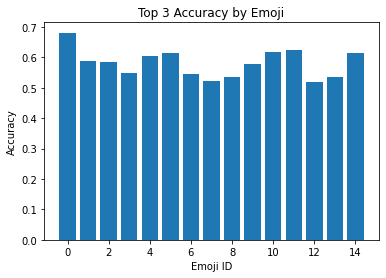

In [29]:
import matplotlib.pyplot as plt

x = result_top_3_aggregated["emoji_id"]
y = result_top_3_aggregated["accuracy"]

# Create the bar chart using the bar function
plt.bar(x, y)

# Add a title and axis labels
plt.title('Top 3 Accuracy by Emoji')
plt.xlabel('Emoji ID')
plt.ylabel('Accuracy')

# Display the plot
plt.show()